In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
latent_dim = 2

encoder_inputs = keras.Input(shape=(17, 1))
x = layers.Conv1D(8, 3, activation='relu', padding='same', dilation_rate=2)(encoder_inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(16, 3, activation='relu', padding='same', dilation_rate=2)(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Flatten()(x)
encoder = layers.Dense(128, activation='relu')(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(encoder)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(encoder)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(128, activation='relu')(latent_inputs)
x = layers.Dense(17 * 8)(x)
x = layers.Reshape((17, 8))(x)
x = layers.Conv1D(16, 3, activation='relu', padding='same')(x)
x = layers.UpSampling1D(2)(x)
x = layers.Conv1D(8, 3, activation='relu', padding='same')(x)
x = layers.UpSampling1D(2)(x)
decoded = layers.Conv1D(1, 3, activation='sigmoid', padding='same')(x)
decoded = layers.Cropping1D(cropping=(0, 68 - 17))(decoded)  # Crop to the desired output shape
decoder = keras.Model(latent_inputs, decoded, name="decoder")
decoder.summary()

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    (data - reconstruction)**2, axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
(x_train) = pd.read_csv('train_dataset.csv')
(x_test) = pd.read_csv('test_dataset.csv')

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
(x_train) = scaler.fit_transform(x_train)
(x_test) = scaler.fit_transform(x_test)

from sklearn.preprocessing import Normalizer

normalizer = Normalizer()
(x_train) = normalizer.fit_transform(x_train)
(x_test) = normalizer.fit_transform(x_test)

#print(x_train)
#print(x_test)
peptides = np.concatenate([x_train, x_test], axis=0)
#mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255
peptides = np.expand_dims(peptides, -1)

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 17, 1)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 17, 8)        32          ['input_1[0][0]']                
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 8, 8)         0           ['conv1d[0][0]']                 
                                                                                                  
 conv1d_1 (Conv1D)              (None, 8, 16)        400         ['max_pooling1d[0][0]']          
                                                                                            

In [2]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
#vae.fit(peptides, batch_size=50, epochs=8)
vae.fit(peptides, batch_size=128, epochs=50)

Epoch 1/50
9/9 [==============================] - 1s 5ms/step - loss: 1.6086 - reconstruction_loss: 1.5324 - kl_loss: 0.0013
Epoch 2/50
9/9 [==============================] - 0s 5ms/step - loss: 1.1482 - reconstruction_loss: 1.0283 - kl_loss: 0.0125
Epoch 3/50
9/9 [==============================] - 0s 5ms/step - loss: 0.6154 - reconstruction_loss: 0.5076 - kl_loss: 0.0246
Epoch 4/50
9/9 [==============================] - 0s 5ms/step - loss: 0.3691 - reconstruction_loss: 0.3581 - kl_loss: 0.0059
Epoch 5/50
9/9 [==============================] - 0s 3ms/step - loss: 0.3493 - reconstruction_loss: 0.3454 - kl_loss: 5.0162e-04
Epoch 6/50
9/9 [==============================] - 0s 3ms/step - loss: 0.3206 - reconstruction_loss: 0.3140 - kl_loss: 6.2648e-04
Epoch 7/50
9/9 [==============================] - 0s 3ms/step - loss: 0.3035 - reconstruction_loss: 0.3008 - kl_loss: 9.9349e-04
Epoch 8/50
9/9 [==============================] - 0s 4ms/step - loss: 0.2955 - reconstruction_loss: 0.2941 - kl_l

27/27 [==============================] - 0s 1ms/step


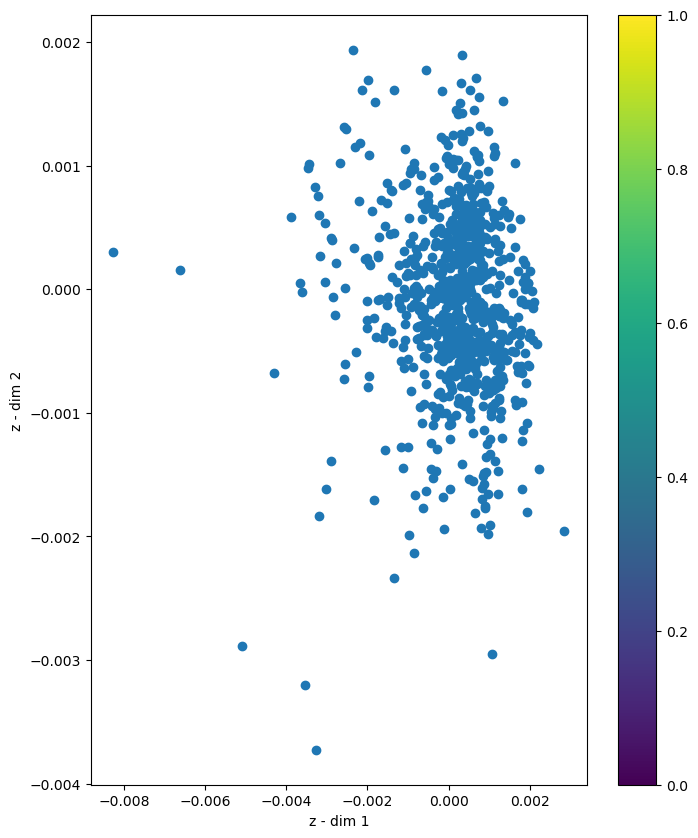

1/1 [==============================] - 0s 4ms/step


1/1 [==============================] - 0s 16ms/step


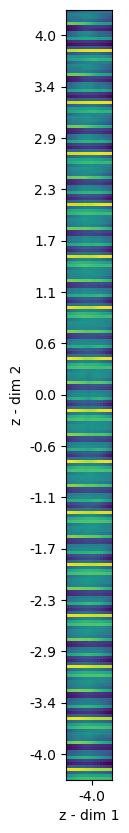

In [5]:
#VIZUALIZACIJA

img_width = 17
img_height = 1
num_channels = 1

def viz_latent_space(encoder, data):
  input_data, target_data = data
  mu, _, _ = encoder.predict(input_data)
  plt.figure(figsize=(8, 10))
  plt.scatter(mu[:, 0], mu[:, 1])
  plt.xlabel('z - dim 1')
  plt.ylabel('z - dim 2')
  plt.colorbar()
  plt.show()
    
def viz_decoded(encoder, decoder, data):
  num_samples = 15
  figure = np.zeros((img_width * num_samples, img_height * num_samples, num_channels))
  grid_x = np.linspace(-4, 4, num_samples)
  grid_y = np.linspace(-4, 4, num_samples)[::-1]
  for i, yi in enumerate(grid_y):
      for j, xi in enumerate(grid_x):
          z_sample = np.array([[xi, yi]])
          x_decoded = decoder.predict(z_sample)
          digit = x_decoded[0].reshape(img_width, img_height, num_channels)
          figure[i * img_width: (i + 1) * img_width,
                  j * img_height: (j + 1) * img_height] = digit
  plt.figure(figsize=(10, 10))
  start_range = img_width // 2
  end_range = num_samples * img_width + start_range + 1
  pixel_range = np.arange(start_range, end_range, img_width)[:num_samples]
  sample_range_x = np.round(grid_x, 1)
  sample_range_y = np.round(grid_y, 1)
  plt.xticks(pixel_range, sample_range_x)
  plt.yticks(pixel_range, sample_range_y)
  plt.xlabel('z - dim 1')
  plt.ylabel('z - dim 2')
  # matplotlib.pyplot.imshow() needs a 2D array, or a 3D array with the third dimension being of shape 3 or 4!
  # So reshape if necessary
  fig_shape = np.shape(figure)
  if fig_shape[2] == 1:
    figure = figure.reshape((fig_shape[0], fig_shape[1]))
  # Show image
  plt.imshow(figure)
  plt.show()
import matplotlib.pyplot as plt

# Plot results
data = (x_train, x_test)
viz_latent_space(encoder, data)
viz_decoded(encoder, decoder, data)